<a href="https://colab.research.google.com/github/gabbmelo/transfer-learning-colab/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A transfer learning project for image classification

This project consists of applying the Transfer Learning method to a Deep Learning network in the Python language within the COLAB environment, as part of the 'BairesDev - Machine Learning Practitioner'  bootcamp [publisehd at the DIO platform](https://web.dio.me/track/coding-the-future-baires-dev-machine-learning-practitioner?tab=about).

As an example, we will use the following project that performs Transfer Learning with the [ImageNet Dataset](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb).

## Importing the necessary modules and frameworks

In [18]:
#tensorflow & keras frameworks:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

#dataviz tool:
import matplotlib.pyplot as plt

#operational system module:
import os

#other modules
import random
import numpy as np
from tensorflow.keras.preprocessing import image


## Loading the dataset into Colab environment

In this step, we download the cats and dogs dataset, extract it, and set the path to the extracted dataset directory. 🐱🐶

In [3]:
# specifying url origin of files to be downloaded as avariable named
# 'dataset_url':
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# using TensorFlow's 'get_file' utility to download the dataset from the
# specified URL and extract its contents. The downloaded file is named
# 'cats_and_dogs.zip':
data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)

# setting the data_dir variable to the path of the extracted dataset directory,
# which is named 'cats_and_dogs_filtered':
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Preprocessing data

In this step, we split the images into training and validation datasets, resizing and seperating them into batches for usage in our machine learning model. 📸📊

In [6]:
# Creaing a training dataset from the images in the data_dir
# directory. This subset uses 80% of the images for training (since
# validation_split=0.2 means 20% will be used for validation).

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(160, 160),
  batch_size=32)

# The subset="training" parameter
# specifies that this is the training subset. The seed=123 parameter ensures
# that the split is reproducible. The images are resized to 160x160 pixels
# (image_size=(160, 160)) and are batched in groups of 32 (batch_size=32).



Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [7]:
# This line creates a validation subset from the images in the data_dir
# directory. It uses the remaining 20% of the images for validation. Hence,
# subset="validation" parameter specifies that this is the validation subset.

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(160, 160),
  batch_size=32)

# Again, the seed=123 parameter ensures that the split is reproducible, the
# images are resized to 160x160 pixels (image_size=(160, 160)) and are batched
# in groups of 32 (batch_size=32)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


Let's take a quick look at smaple images 📸🖼️ from the dataset by:

1.  Collecting image paths;
2.  Selecting 8 random images;
3.  Resizing and concatenatting them into a single image;
4.  Displaying the result.

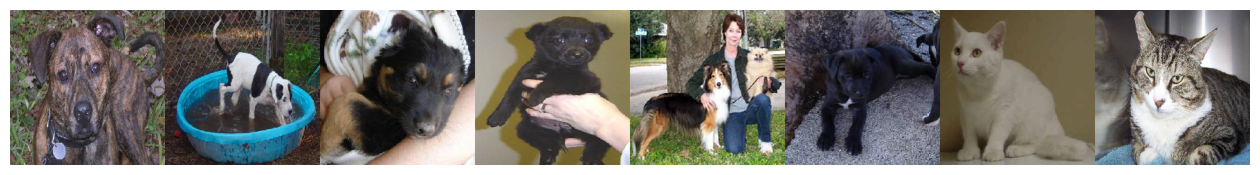

In [23]:
# Walking through the directory tree rooted at data_dir and
# collecting the paths of all image files with extensions .jpg, .png, or
# .jpeg

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]

# Generating a list of 8 random indices, each
# corresponding to a random image from the images list:

idx = [int(len(images) * random.random()) for i in range(8)]

# Loading the selected indices and resizing them to 224x224 pixels:

imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

# Converting the loaded images to numpy arrays and concatenating them
# horizontally into a single image:

concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

# Creating a figure with a specified size (16x4 inches) and displaying the
# concatenated image:

plt.figure(figsize=(16, 4));
plt.imshow(concat_image);
plt.axis('off'); # Hide axes for better visualization plt.show()

## Loading the training dataset into a pretrained model for fine-tuning

In this step, we load a pre-trained ResNet50 model with a specified input shape, exclude the top layer (i.e., the final layer), and use the weights pre-trained on the ImageNet dataset.

Quoting the referenced source material: "this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much." 📸🔍

Here's a breakdown of what each part does:

1. `pretrained_model = tf.keras.applications.ResNet50(...)`: This line initializes a ResNet50 model.

2. `input_shape=(160, 160, 3)`: This parameter specifies the shape of the input images. In this case, the images are 160x160 pixels with 3 color channels (RGB).

3. `include_top=False`: This parameter indicates that the top (final) fully connected layer of the model should not be included. This is useful when you want to use the model for feature extraction or fine-tuning on a different task.

4. `weights='imagenet'`: This parameter specifies that the model should be initialized with weights pre-trained on the ImageNet dataset. This allows the model to leverage the knowledge it has gained from training on a large and diverse dataset.

In [29]:
pretrained_model = tf.keras.applications.ResNet50(input_shape=(160, 160, 3),
                           include_top=False,
                           weights='imagenet')

## Freezing the layers of the base model

It is important to freeze the layers of the pre-trained model, ensuring that the pre-trained model's weights remain unchanged during the initial training phase. This can help speed up training and improve performance, especially when we have a small dataset. 🧠🔒

Again quoting the referenced material: "By setting the trainable flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end."

In [27]:
# When you set trainable to False, it means that the weights of the model's
# layers will not be updated during training

pretrained_model.trainable = False

## Creating the final model


Adding additional layers to the model to adapt it to our specific task.
This step creates a sequential model using TensorFlow's Keras API.

Here's a breakdown of what each part does:

1. `model = models.Sequential([...])`: This line initializes a sequential model, which is a linear stack of layers.

2. `pretrained_model`: This is the pre-trained ResNet50 model that we loaded earlier. It serves as the base of the new model.

3. `layers.GlobalAveragePooling2D()`: This layer performs global average pooling on the output of the pre-trained model. It reduces the spatial dimensions of the feature maps to a single value per feature map, resulting in a 1D vector for each image.

4. `layers.Dense(2, activation='softmax')`: This is a fully connected (dense) layer with 2 output units and a softmax activation function. The softmax activation function is used for multi-class classification, and in this case, it is used for binary classification (two classes).

In summary, this code creates a new model by stacking the pre-trained ResNet50 model, a global average pooling layer, and a dense layer with a softmax activation function for binary classification. This model can be now used to classify images into two categories. 🐱🐶

In [28]:
model = models.Sequential([
  pretrained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(2, activation='softmax') # Para duas classes
])

## Model Compilation

Let's compile the model by defining the optimizer and the loss function. We specify the optimizer, loss function, and evaluation metrics.

Here's a breakdown of each part:

1. **Optimizer**:
   ```python
   optimizer=optimizers.Adam(learning_rate=0.0001)
   ```
   This line sets the optimizer to Adam with a learning rate of 0.0001. The Adam optimizer is an adaptive learning rate optimization algorithm that's widely used in training deep learning models.

2. **Loss Function**:
   ```python
   loss='sparse_categorical_crossentropy'
   ```
   This line sets the loss function to sparse categorical cross-entropy. This loss function is used for multi-class classification problems where the target labels are integers. It's suitable for classification tasks with more than two classes.

3. **Metrics**:
   ```python
   metrics=['accuracy']
   ```
   This line specifies that the model should track accuracy as a metric during training and evaluation. Accuracy measures the proportion of correctly classified samples.

In summary, this code compiles the model with the Adam optimizer, sparse categorical cross-entropy loss function, and accuracy as the evaluation metric. This setup is commonly used for training classification models. 📊🔧


In [34]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
       loss='sparse_categorical_crossentropy',
       metrics=['accuracy'])

## Model Training



Train the model using the training and validation data. In this step, we train a Keras model using the training and validation datasets. Here's a breakdown of each part:

1. **Train the Model**:
   ```python
   history = model.fit(train_dataset,
             epochs=10,
             validation_data=validation_dataset)
   ```
   This line trains the model on the `train_dataset` for 10 epochs. The `validation_data` parameter specifies the validation dataset to evaluate the model's performance after each epoch. The `fit` method returns a `history` object that contains the training and validation metrics for each epoch.

In summary, this code trains the model using the training dataset and evaluates its performance on the validation dataset over 10 epochs. 📊🔧


In [36]:
# Train the model and store the training history
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.5581 - loss: 0.9821 - val_accuracy: 0.5983 - val_loss: 0.8376
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.5861 - loss: 0.8051 - val_accuracy: 0.6067 - val_loss: 0.7965
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.5801 - loss: 0.7733 - val_accuracy: 0.5800 - val_loss: 0.7775
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.5910 - loss: 0.7331 - val_accuracy: 0.6100 - val_loss: 0.7678
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.6092 - loss: 0.7150 - val_accuracy: 0.6083 - val_loss: 0.7588
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.6204 - loss: 0.6921 - val_accuracy: 0.6117 - val_loss: 0.7506
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.6333 - loss: 0.6785 - val_accuracy: 0.5833 - val_loss: 0.7525
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.6071 - loss: 0.6687 - val_accuracy: 0.5983 - v

## Model Evaluation


After training, we can evaluate the model's performance on the validation data. In this step, we evaluate the trained model on the validation dataset and print the accuracy.

Here's a breakdown of each part:

1. **Evaluate the Model**:
   ```python
   loss, accuracy = model.evaluate(validation_dataset)
   ```
   This line evaluates the model on the `validation_dataset`. It returns the loss and accuracy of the model on the validation data.

2. **Print the Accuracy**:
   ```python
   print(f"Accuracy: {accuracy * 100:.2f}%")
   ```
   This line prints the accuracy of the model as a percentage, formatted to two decimal places.

In summary, this code evaluates the model's performance on the validation dataset and prints the accuracy. 📊🔍


In [37]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.5641 - loss: 0.7665
Accuracy: 59.67%


## Displaying the results



Visualize the loss and accuracy during training. In this step, we visualize the training and validation accuracy over epochs. Here's a breakdown of each part:

1. **Plot Training Accuracy**:
   ```python
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   ```
   This line plots the training accuracy over epochs. The `history.history['accuracy']` contains the accuracy values for each epoch during training.

2. **Plot Validation Accuracy**:
   ```python
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   ```
   This line plots the validation accuracy over epochs. The `history.history['val_accuracy']` contains the accuracy values for each epoch during validation.

3. **Set Plot Title**:
   ```python
   plt.title('Model Accuracy')
   ```
   This line sets the title of the plot to "Model Accuracy".

4. **Set X-axis Label**:
   ```python
   plt.xlabel('Epochs')
   ```
   This line sets the label for the x-axis to "Epochs".

5. **Set Y-axis Label**:
   ```python
   plt.ylabel('Accuracy')
   ```
   This line sets the label for the y-axis to "Accuracy".

6. **Add Legend**:
   ```python
   plt.legend()
   ```
   This line adds a legend to the plot to differentiate between training and validation accuracy.

7. **Show Plot**:
   ```python
   plt.show()
   ```
   This line displays the plot.

In summary, this code visualizes the training and validation accuracy over epochs, helping to understand the model's performance during training. 📊📈

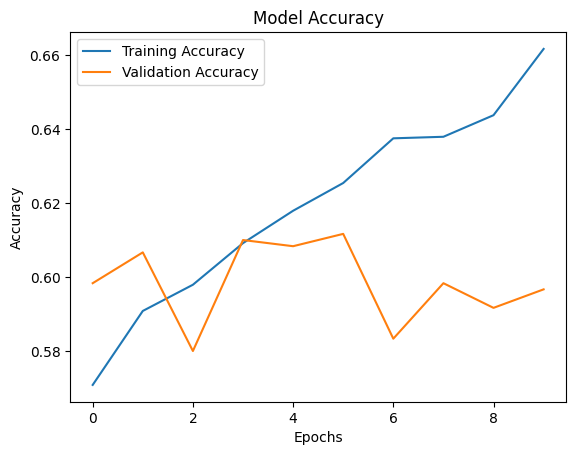

In [38]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()